# Treg_ATAC-seq_DataAnalysis_Pipeline

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nx
import gc
import psutil
import scipy.stats
#import Thestral
from scipy.stats.mstats import gmean

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import community
import matplotlib.gridspec as gridspec
import random
sys.setrecursionlimit(20000)
import re

In [43]:
#Functions
def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def meanCenter(L):
    m=np.mean(L)
    return [i-m for i in L]

def log10(L):
    if L==0:
        return 1000000
    if L!=0:
        return -math.log(L,10)

def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def ReadBed(BedFile):
    BedDF=pd.read_table(BedFile,sep='\t',header=None,index_col=None)
    BedDF.index=BedDF[3]
    return BedDF

def SaveTable(DF,FileName):DF.to_csv(FileName,sep='\t')
def SaveBed(BedDF,FileName):BedDF.to_csv(FileName,sep='\t',index=False,header=False)

def Get_FDR(PSeries):
    return pd.Series(p_adjust_bh(PSeries.values),index=PSeries.index)

def Ttest(A,B,Index_List):
    return pd.Series(scipy.stats.ttest_ind(A,B,axis=1)[1],index=Index_List)
    
def Diff_FDR(A,B,fdc,fdr):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    print len(Indexs)
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    FDR=pd.Series(p_adjust_bh(Pval.values), index=Indexs)
    return FDC,FDR,list(A2[(FDC>fdc)&(FDR<fdr)].index),list(A2[(FDC<-fdc)&(FDR<fdr)].index)
    

def Diff_Pval(A,B,fdc,p):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))           
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    return FDC,Pval,list(A2[(FDC>fdc)&(Pval<p)].index),list(A2[(FDC<-fdc)&(Pval<p)].index)

In [44]:

inDir="./ATAC-seq/"
inDir_Treg="./ATAC-seq_Treg/"


# Input file
PeakCountF=os.path.join(inDir_Treg, "SourceData/atac.count")
PeakBedF=os.path.join(inDir_Treg, "SourceData/atac.merged.peak.list")
PeakBedAno=os.path.join(inDir_Treg, "SourceData/atac.merged.peak.list.ano.txt")
outDir=os.path.join(inDir_Treg, "OutPut")


#Genomica Results
GenomicaF=os.path.join(inDir_Treg, "SourceData/GenomicMotifEnrichment.topNum100.Heatmap.txt")



#Signature Gene sets
Signature=os.path.join(inDir, "SourceData/SignatureGenes.txt")
Signature_KEGG=os.path.join(inDir, "SourceData/KEGGSignatureGenes.txt")
Signature_MSig=os.path.join(inDir, "SourceData/MSigSignatureGenes.txt")


#Gene regulatory regions (from "GREAT": "Basal plus extension", Proximal: 5.0kb upstream,  1.0 kb downstream, plus Distal: up to 1000.0 kb)      
RegulatoryRegions=os.path.join(inDir, "SourceData/gene_BasalPlusExtend_5_1_500.bed")


#Cytokins
CytokinsFile=os.path.join(inDir, "SourceData/CytokineRegistry.November_2015.txt")




In [5]:
# Remove peaks in chrY
outDir=os.path.join(outDir,'RemoveChrY/')
Mkdir(outDir)

CountDF=ReadTable(PeakCountF)
BedDF=pd.read_table(PeakBedF,sep='\t',header=None)
BedDF.index=BedDF[3]
BedDF=BedDF[(BedDF[0]!='chrY')]
CountDF=CountDF.loc[BedDF.index]

outCount=os.path.join(outDir,'PeakCount.removeY.txt')
outBed=os.path.join(outDir,'PeakBed.removeY.bed')

BedDF.to_csv(outBed,sep='\t',header=False,index=False)
CountDF.to_csv(outCount,sep='\t')



In [6]:
#Normalized and log
def NormLog(DF,method,O,outfile):
    if method=='QNorm':
        print 'Do QNorm...'
        rank_mean=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
        DF=DF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
        outfile=outfile+'.QNorm'
        print 'QNorm Done!'
    if method=='DEseq':
        print 'Do DEseq...'
        SizeFactor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
        DF=DF/SizeFactor
        outSizeFactor=os.path.join(outDir,'DEseq_sizeFactors.txt')
        SizeFactor.to_csv(outSizeFactor,sep='\t')
        outfile=outfile+'.DEseq'
        print 'DEseq Done!'
    DFlog=(DF+1).apply(np.log2)
    if O:
        print 'Output file...'
        outfilelog=os.path.join(outDir,'PeakCount.RemoveY.'+method+'_Normalized.log2.txt')
        outfile=os.path.join(outDir,'PeakCount.RemoveY.'+method+'_Normalized.txt')
        DF.to_csv(outfile,sep='\t')
        DFlog.to_csv(outfilelog,sep='\t')
    return DF,DFlog

#QNorm
QNormDF,QNormDFlog=NormLog(CountDF,'QNorm',True,outCount[:-3])


Do QNorm...
QNorm Done!
Output file...


In [7]:
Samples=list(QNormDF)
NormSamples=[i for i in Samples if 'P' not in i]
SLESamples=[i for i in Samples if 'P' in i]
SamplesColorsDict={'D':'darkblue','P':'firebrick','F':'lightpink','M':'skyblue'}
AnoDF=pd.DataFrame({'State':[i[0] for i in Samples],'Gender':['F']*len(Samples)},index=Samples)
AnoDF['State_Color']=[SamplesColorsDict[i] for i in AnoDF['State']]



# Normal-SLE  Differantial Peaks

In [8]:
Dir=os.path.join(outDir,'Normal-SLE_DifferentialPeaks')
Mkdir(Dir)


In [9]:
QNormDFlog_Norm=QNormDFlog[QNormDFlog.apply(max,axis=1)>4][NormSamples]
QNormDFlog_SLE=QNormDFlog[QNormDFlog.apply(max,axis=1)>4][SLESamples]


In [10]:
FDC,FDR,Norm_Peaks,SLE_Peaks=Diff_Pval(QNormDFlog_Norm,QNormDFlog_SLE,1,0.05)
SaveBed(BedDF.loc[Norm_Peaks], os.path.join(Dir,'Norm.specificPeaks.bed'))
SaveBed(BedDF.loc[SLE_Peaks], os.path.join(Dir,'SLE.specificPeaks.bed'))
SaveBed(BedDF.loc[SLE_Peaks+Norm_Peaks], os.path.join(Dir,'All.DiffPeaks.bed'))
SaveTable(QNormDFlog.loc[SLE_Peaks+Norm_Peaks], os.path.join(Dir,'All.DiffPeaks.QNormLogCount.txt'))



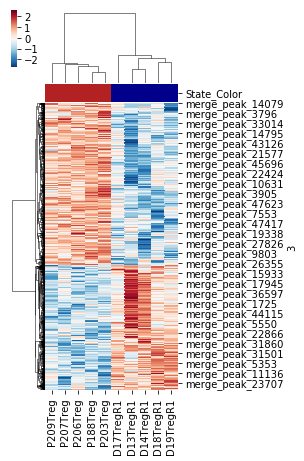

In [11]:
DiffDF=QNormDFlog.loc[SLE_Peaks+Norm_Peaks].apply(scipy.stats.zscore,axis=1)
fig=sns.clustermap(DiffDF,method='average',cmap='RdBu_r',figsize=(3,7),metric='correlation',col_colors=AnoDF[['State_Color']],row_cluster=True,col_cluster=True,linecolor=None)               
fig.savefig(os.path.join(Dir, 'All.DiffPeaks.QNormLogCount.zscore.pdf'))
plt.show()   
    

# Volcano Plot

In [12]:
FDC=QNormDFlog_SLE.apply(np.mean,axis=1)-QNormDFlog_Norm.apply(np.mean,axis=1)
Pval=scipy.stats.ttest_ind(QNormDFlog_SLE,QNormDFlog_Norm,axis=1)[1]
VolDF=pd.DataFrame({'FOLD':FDC,'pvalue':Pval},index=FDC.index)
VolDF['pvalue']=[-np.log10(i) for i in Pval]
FDC=p_adjust_bh(Pval)
VolDF['FDR']=[-np.log10(i) for i in FDC]


In [13]:
def VolcanoPlot(Dif,Dir,Label):
    Dif1=Dif[((Dif['FOLD']>-1)&(Dif['FOLD']<1))|(Dif['pvalue']<1.30001)]  
    Dif2=Dif[(Dif['FOLD']<-1)&(Dif['pvalue']>1.3)]                                                       
    Dif3=Dif[(Dif['FOLD']>1)&(Dif['pvalue']>1.3)]                                                     
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(6,4.5))
    ax=fig.add_axes([0.2,0.2,0.7,0.7])
    ax.tick_params(axis='y',length=7,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=15,direction='out')
    ax.set_ylabel('-log10 P-value',fontsize=15)
    ax.set_xlabel('log2 mean FoldChange',fontsize=15)
    ax.set_xlim([-5,5])
    ax.set_ylim([0,7])
    ax.scatter(Dif1['FOLD'],Dif1['pvalue'],c='darkgray',alpha=0.2,s=4,edgecolor='none')
    ax.scatter(Dif2['FOLD'],Dif2['pvalue'],c=Dif2['FDR'],cmap='Blues',alpha=0.8,s=4,edgecolor='none',vmin=0.3, vmax=2)         
    ax.scatter(Dif3['FOLD'],Dif3['pvalue'],c=Dif3['FDR'],cmap='Reds',alpha=0.8,s=4,edgecolor='none',vmin=0.3, vmax=2)               

    ax.axhline(y=1.3,ls='--',color='darkgray',alpha=0.6,lw=1)
    ax.axvline(x=-1,ls='--',color='darkgray',alpha=0.6,lw=1)
    ax.axvline(x=1,ls='--',color='darkgray',alpha=0.6,lw=1)
        
    plt.savefig(os.path.join(Dir,Label+'_Volcanoplot.pdf'),dpi=1000)
    plt.show()
    return 


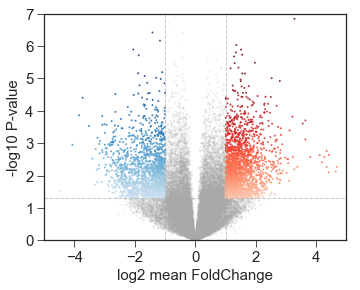

In [14]:
VolcanoPlot(VolDF,Dir,'Treg')


# ATAC-seq signature score 

In [21]:
Dir=os.path.join(outDir,'ATACSignatureScore')
Mkdir(Dir)


In [22]:
PeakAnoDF=ReadTable(PeakBedAno)
SignatureDF=ReadTable(Signature)

def Norm01(L):
    M=min(L)
    R=max(L)-M
    return [(i-M)/float(R) for i in L]

def ViolinPlot(DF,label, x,y,hue='State',hueDict={'D':'darkblue','P':'firebrick'}):
    Title=''
    for i in list(set(DF[x])):
        df=DF[DF[x]==i]
        A=df[df[hue]=='D'][y]
        B=df[df[hue]=='P'][y]
        Title=Title+i+':'+str(scipy.stats.ttest_ind(A.values,B.values)[1])+'_'
    
    fig=plt.figure(figsize=(2*len(set(DF[x])),3))
    #ax=fig.add_axes([10.0/(10+0.45*len(list(DF))),0.2,0.95-10.0/(10+0.45*len(list(DF))),0.7])
    ax=fig.add_axes([0.2,0.2,0.8,0.7])
    #sns.violinplot(x=x, y=y, hue="State",data=DF, palette=hueDict,split=False,  inner=None,ax=ax) 
    
    sns.boxplot(x=x, y=y, hue=hue,data=DF,palette=hueDict,linewidth=1,ax=ax,saturation=1,fliersize=1)                   
    sns.swarmplot(x=x,y=y,hue=hue,data=DF,palette=hueDict,size=4,linewidth=0,ax=ax,dodge=True)
    
    ax.set_title(Title)
#    ax.set_ylim(-1,5)
    plt.savefig(os.path.join(Dir, label+'.pdf'))
    plt.show()
    

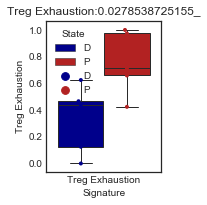

In [31]:
List=[]
for i in list(SignatureDF['Treg Exhaustion'].dropna()):
    List=List+list(PeakAnoDF[PeakAnoDF['Gene Name']==i].index)
SignatureScoreDF=pd.DataFrame(QNormDFlog.loc[List].apply(sum,axis=0))
SignatureScoreDF['Treg Exhaustion']=Norm01(SignatureScoreDF[0])
SignatureScoreDF['Signature']=['Treg Exhaustion']*len(SignatureScoreDF)
SignatureScoreDF['State']=[i[0] for i in list(SignatureScoreDF.index)]
ViolinPlot(SignatureScoreDF,"Treg_Exhaustion", 'Signature','Treg Exhaustion',hue='State',hueDict={'D':'darkblue','P':'firebrick'})    


In [38]:
List=[]
for i in list(SignatureDF['Type I Interferon response'].dropna()):
    List=List+list(PeakAnoDF[PeakAnoDF['Gene Name']==i].index)
SignatureScoreDF['Type I Interferon response']=Norm01(QNormDFlog.loc[List].apply(sum,axis=0))



In [40]:

from sklearn.metrics import r2_score
def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

def get_r2_python(x_list, y_list):
    n = len(x_list)
    x_bar = sum(x_list)/n
    y_bar = sum(y_list)/n
    x_std = math.sqrt(sum([(xi-x_bar)**2 for xi in x_list])/(n-1))
    y_std = math.sqrt(sum([(yi-y_bar)**2 for yi in y_list])/(n-1))
    zx = [(xi-x_bar)/x_std for xi in x_list]
    zy = [(yi-y_bar)/y_std for yi in y_list]
    r = sum(zxi*zyi for zxi, zyi in zip(zx, zy))/(n-1)
    return r**2


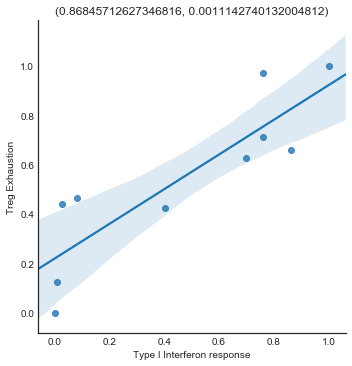

0.754217780175


In [41]:
fig=sns.lmplot(x='Type I Interferon response',y='Treg Exhaustion',data=SignatureScoreDF)            
plt.title(scipy.stats.pearsonr(SignatureScoreDF['Treg Exhaustion'],SignatureScoreDF['Type I Interferon response']))
fig.savefig(os.path.join(Dir,'IFN1Response_TregExhaustion_Correlation.pdf'))
plt.show()
print get_r2_python(SignatureScoreDF['Treg Exhaustion'],SignatureScoreDF['Type I Interferon response'])



# Genomica TF enrichment 

In [19]:
Dir=os.path.join(outDir,'TF_enrichment')
Mkdir(Dir)


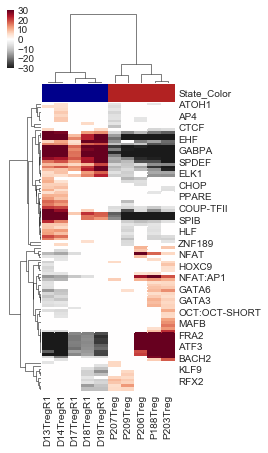

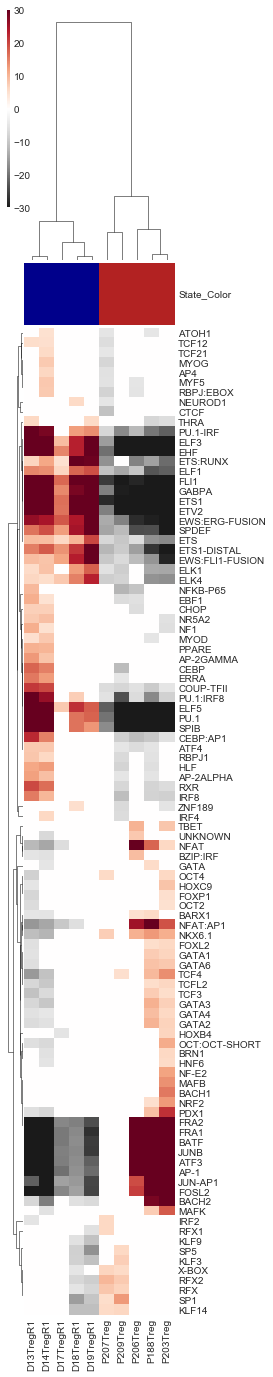

In [20]:
GenomicaDF=ReadTable(GenomicaF)
fig=sns.clustermap(GenomicaDF,method='average',cmap='RdGy_r',figsize=(3,7),metric='correlation',col_colors=AnoDF[['State_Color']],row_cluster=True,col_cluster=True,linecolor=None, vmin=-30,vmax=30)               
fig.savefig(os.path.join(Dir, 'Genomica_DiffTFs.pdf'))
plt.show() 

fig=sns.clustermap(GenomicaDF,method='average',cmap='RdGy_r',figsize=(3,24),metric='correlation',col_colors=AnoDF[['State_Color']],row_cluster=True,col_cluster=True,linecolor=None,yticklabels=GenomicaDF.index, vmin=-30,vmax=30)               
fig.savefig(os.path.join(Dir, 'Genomica_DiffTFs.long.pdf'))
plt.show() 

